In [1]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

# magic functions for jupyter notebook plotting
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# confirm that you are currently using the newest version of SDK (2.16.2)
import allensdk
allensdk.__version__

'2.16.2'

In [3]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

In [4]:
# import behavior projet cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

cache = VisualBehaviorOphysProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)
# if we needed to download the data we could have used the following line
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_root)  

# Get table describing ophys experiments *MOST USEFUL TABLE TO LOOK AT
ophys_experiments = cache.get_ophys_experiment_table()  

print('Number of ophys experiments = {}'.format(len(ophys_experiments)))

# get metadata tables
#behavior_sessions = cache.get_behavior_session_table()


#ophys_sessions = cache.get_ophys_session_table()


#ophys_cells = cache.get_ophys_cells_table()

#print number of items in each table for all imaging and behavioral sessions
#print('Number of behavior sessions = {}'.format(len(behavior_sessions)))
#print('Number of ophys sessions = {}'.format(len(ophys_sessions)))

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as data_formatting

import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_data_formatting

import pickle as pickle

Number of ophys experiments = 1936


/opt/conda/lib/python3.10/site-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [5]:
ophys_experiments = ophys_experiments.sort_values(by=['cre_line', 'mouse_id', 'date_of_acquisition'])
#ophys_experiments[['mouse_id', 'cre_line', 'sex', 'date_of_acquisition', 'session_type', 'session_number', 'prior_exposures_to_image_set', 'prior_exposures_to_session_type']]

In [6]:
# Get only the OPHYS_4 experiments with no prior exposure to the novel image set
subset_ophys_experiments = ophys_experiments[(ophys_experiments.project_code=='VisualBehaviorMultiscope4areasx2d')&
                        (ophys_experiments.session_number==4) &
                        (ophys_experiments.prior_exposures_to_image_set==0)]

# Sort the filtered experiments by genotype, sex, mouse ID
subset_ophys_experiments = subset_ophys_experiments.sort_values(by=['cre_line', 'targeted_structure', 'sex', 'mouse_id'])


#subset_ophys_experiments[['cre_line', 'targeted_structure', 'sex', 'mouse_id', 'session_type', 'prior_exposures_to_image_set', 'prior_exposures_to_session_type']]

# there are 4 Slc17a7 animals, 4 Sst animals, and 4 Vip animals

In [7]:
# Get only the slc17a7 experiments with no prior exposure to the novel image set
slc17a7_ophys_experiments = subset_ophys_experiments[(subset_ophys_experiments.cre_line=='Slc17a7-IRES2-Cre')]

# Get only the Sst experiments
sst_ophys_experiments = subset_ophys_experiments[(subset_ophys_experiments.cre_line=='Sst-IRES-Cre')]

# Get only the Vip experiments
vip_ophys_experiments = subset_ophys_experiments[(subset_ophys_experiments.cre_line=='Vip-IRES-Cre')]


In [8]:
# CHANGE THIS TO ITERATE OVER GENOTYPES
curr_mouse_genotype = vip_ophys_experiments

# CHANGE THIS TO SAVE TO THE CORRECT FOLDER
end_folder = 'vip-cre'


In [9]:
# Get the list of mouse ids for the current genotype
mouse_id_list = curr_mouse_genotype.mouse_id.unique()
mouse_id_list = sorted(mouse_id_list)
mouse_id_list

['489065', '499478', '550603', '554115']

In [10]:
#pickle_path = '/root/capsule/my_results/pickle_stackedcells_imagechange/' + end_folder + '/'

# path for slc17a7:
pickle_path = '/root/capsule/my_results/pickle_stackedcells_imagechange/vip-cre/' 


image_path = '/root/capsule/my_results/figures/concatenated_imagechange_cellavg/'

# Generate svg save name
curr_name_svg = end_folder + '_concat_imagechange.svg'


In [11]:
# # for mouse_id in mouse_id_list:
#     curr_name = 'stacked_data_df_' + mouse_id + '.pkl'
#     curr_df = pd.read_pickle(file_path+curr_name)
    
#     # Sort the filtered experiments by cell_id
#     curr_df = curr_df.sort_values(by=['mouse_id', 'cell_specimen_id', 'stimulus_presentations_id'])
    
#     # Get only the stimulus presentations with image change novel to novel
#     stim_response_stack_nn = curr_df[(curr_df.prev_image_novel==True)&
#                         (curr_df.is_image_novel==True)]

#     #novel to familiar
#     stim_response_stack_nf = curr_df[(curr_df.prev_image_novel==True) &
#                                          (curr_df.is_image_novel==False)]

#     #familiar to familiar
#     stim_response_stack_ff = curr_df[(curr_df.prev_image_novel==False) &
#                                              (curr_df.is_image_novel==False)]

#     #familiar to novel
#     stim_response_stack_fn = curr_df[(curr_df.prev_image_novel==False) &
#                                              (curr_df.is_image_novel==True)]
#     stim_response_stack_list = [stim_response_stack_nn, stim_response_stack_nf, stim_response_stack_ff, stim_response_stack_fn]
#     timestamps = curr_df.trace_timestamps.values[0]

#     #Initialize a data list which will eventually contain n_cells rows and 4 columns (1 for each image change type)
#     data_list = []

#     # Run a loop over each cell:
#     for cell_specimen_id in curr_df.cell_specimen_id.unique():

#         cell_mean_list = []

#         for stim_response_imagechange in stim_response_stack_list:
#             # get the relevant data nn
#             cell_df = stim_response_imagechange[(stim_response_imagechange.cell_specimen_id==cell_specimen_id)]
#             # get the average dff trace
#             mean_trace = cell_df.dff_trace.mean()
#             cell_mean_list += [mean_trace]
#         data_list.append(list(cell_mean_list))
    
#     data_array = np.array(data_list)

#     data_flat = data_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)


    
    

In [12]:
#curr_df[['mouse_id','cell_specimen_id']]

In [13]:
# # # CALCULATE HIT RATE
# single_cell_df = curr_df[(curr_df.cell_specimen_id==1120120150)]
# single_cell_df

# single_cell_df.groupby(['image_change_type', 'stimulus_presentations_id']).count().reset_index().groupby(['image_change_type']).count()[['stimulus_presentations_id']]

# single_cell_df.groupby(['image_change_type'])['miss'].sum()
    
# single_cell_df.groupby(['image_change_type'])['hit'].sum()

In [14]:
# # Get only the stimulus presentations with image change novel to novel
# stim_response_stack_nn = single_cell_df[(single_cell_df.prev_image_novel==True)&
#                         (single_cell_df.is_image_novel==True)]

# #novel to familiar
# stim_response_stack_nf = single_cell_df[(single_cell_df.prev_image_novel==True) &
#                                          (single_cell_df.is_image_novel==False)]

# #familiar to familiar
# stim_response_stack_ff = single_cell_df[(single_cell_df.prev_image_novel==False) &
#                                          (single_cell_df.is_image_novel==False)]

# #familiar to novel
# stim_response_stack_fn = single_cell_df[(single_cell_df.prev_image_novel==False) &
#                                          (single_cell_df.is_image_novel==True)]

In [15]:
# cell_df = stim_response_stack_ff

# cell_hit_df = stim_response_stack_ff[(stim_response_stack_ff.hit==True)]

# cell_miss_df = stim_response_stack_ff[(stim_response_stack_ff.miss==True)]

In [16]:
vip_stacked_dict = {}
vip_stacked_df = pd.DataFrame()
for mouse_id in mouse_id_list:
    curr_name = 'stacked_data_df_' + mouse_id + '.pkl'
    stacked_data_df = pd.read_pickle(pickle_path+curr_name)
    
    stacked_data_df = stacked_data_df.merge(subset_ophys_experiments, left_on='ophys_experiment_id', 
                                      right_index=True, how='left')

    
    
    vip_stacked_dict[mouse_id] = stacked_data_df
    vip_stacked_df = pd.concat([vip_stacked_df, stacked_data_df])
    

In [17]:
# curr_df = vip_stacked_dict[mouse_id_list[0]]
curr_df = vip_stacked_df

In [18]:
# Sort the filtered experiments by cell_id
curr_df = curr_df.sort_values(by=['mouse_id', 'cell_specimen_id', 'stimulus_presentations_id'])


In [19]:
curr_df.columns

Index(['stimulus_presentations_id', 'cell_specimen_id', 'dff_trace',
       'trace_timestamps', 'dff_mean_response', 'dff_baseline_response',
       'p_value_gray_screen', 'ophys_frame_rate', 'data_type', 'event_type',
       ...
       'passive', 'experience_level', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'date_of_acquisition', 'equipment_name', 'published_at',
       'isi_experiment_id', 'file_id'],
      dtype='object', length=104)

In [20]:
curr_df.groupby(['mouse_id', 'cell_specimen_id']).count().reset_index().groupby(['mouse_id']).count()[['cell_specimen_id']]


,cell_specimen_id
mouse_id,
489065,78
499478,88
550603,114
554115,81


In [21]:
# Get only the stimulus presentations with image change novel to novel
stim_response_stack_nn = curr_df[(curr_df.prev_image_novel==True)&
                        (curr_df.is_image_novel==True)]

#novel to familiar
stim_response_stack_nf = curr_df[(curr_df.prev_image_novel==True) &
                                         (curr_df.is_image_novel==False)]

#familiar to familiar
stim_response_stack_ff = curr_df[(curr_df.prev_image_novel==False) &
                                         (curr_df.is_image_novel==False)]

#familiar to novel
stim_response_stack_fn = curr_df[(curr_df.prev_image_novel==False) &
                                         (curr_df.is_image_novel==True)]

In [22]:
stim_response_stack_list = [stim_response_stack_nn, stim_response_stack_nf, stim_response_stack_ff, stim_response_stack_fn]
timestamps = curr_df.trace_timestamps.values[0]

#Initialize a data list which will eventually contain n_cells rows and 4 columns (1 for each image change type)
dff_all_list = []
dff_hit_list = []
dff_miss_list = []

filtevent_all_list = []
filtevent_hit_list = []
filtevent_miss_list = []

# Run a loop over each cell:
for cell_specimen_id in curr_df.cell_specimen_id.unique():

    cell_dff_list = []
    cell_dff_hit_list = []
    cell_dff_miss_list = []
    
    cell_filtevent_list = []
    cell_filtevent_hit_list = []
    cell_filtevent_miss_list = []
    
    for stim_response_imagechange in stim_response_stack_list:
        # get the relevant data for each cell
        cell_df = stim_response_imagechange[(stim_response_imagechange.cell_specimen_id==cell_specimen_id)]
        cell_hit_df = stim_response_imagechange[(stim_response_imagechange.cell_specimen_id==cell_specimen_id) & 
                                                (stim_response_imagechange.hit==True)]
        cell_miss_df = stim_response_imagechange[(stim_response_imagechange.cell_specimen_id==cell_specimen_id) & 
                                                (stim_response_imagechange.miss==True)]
        
        # get the average dff trace (all trials)
        mean_trace = cell_df.dff_trace.mean()
        cell_dff_list += [mean_trace]
        # get the average filtered events trace (all trials)
        mean_filtevent = cell_df.filtered_events_trace.mean()
        cell_filtevent_list += [mean_filtevent]
        
        
        if cell_hit_df.empty:
            mean_hit_trace = np.full_like(mean_trace, np.nan)
            mean_filtevent_hit = np.full_like(mean_filtevent, np.nan)
        else:
            # get the average dff trace (hit trials)
            mean_hit_trace = cell_hit_df.dff_trace.mean()
            # get the average filtered events trace (hit trials)
            mean_filtevent_hit = cell_hit_df.filtered_events_trace.mean()
            
        cell_dff_hit_list += [mean_hit_trace]
        cell_filtevent_hit_list += [mean_filtevent_hit]
        
        if cell_miss_df.empty:
            mean_miss_trace = np.full_like(mean_trace, np.nan)
            mean_filtevent_miss = np.full_like(mean_filtevent, np.nan)
        else:
            # get the average dff trace (miss trials)
            mean_miss_trace = cell_miss_df.dff_trace.mean()
            # get the average filtered events trace (miss trials)
            mean_filtevent_miss = cell_miss_df.filtered_events_trace.mean()
        
        cell_dff_miss_list += [mean_miss_trace]
        cell_filtevent_miss_list += [mean_filtevent_miss]
        
    dff_all_list.append(list(cell_dff_list))
    dff_hit_list.append(list(cell_dff_hit_list))
    dff_miss_list.append(list(cell_dff_miss_list))
    
    filtevent_all_list.append(list(cell_filtevent_list))
    filtevent_hit_list.append(list(cell_filtevent_hit_list))
    filtevent_miss_list.append(list(cell_filtevent_miss_list))
    

In [23]:
# Store all, hit, and miss lists in a list
dff_groups_list = [dff_all_list, dff_hit_list, dff_miss_list]

filtevent_groups_list = [filtevent_all_list, filtevent_hit_list, filtevent_miss_list]

groups_types_list = ['all_trials', 'hit_trials', 'miss_trials']

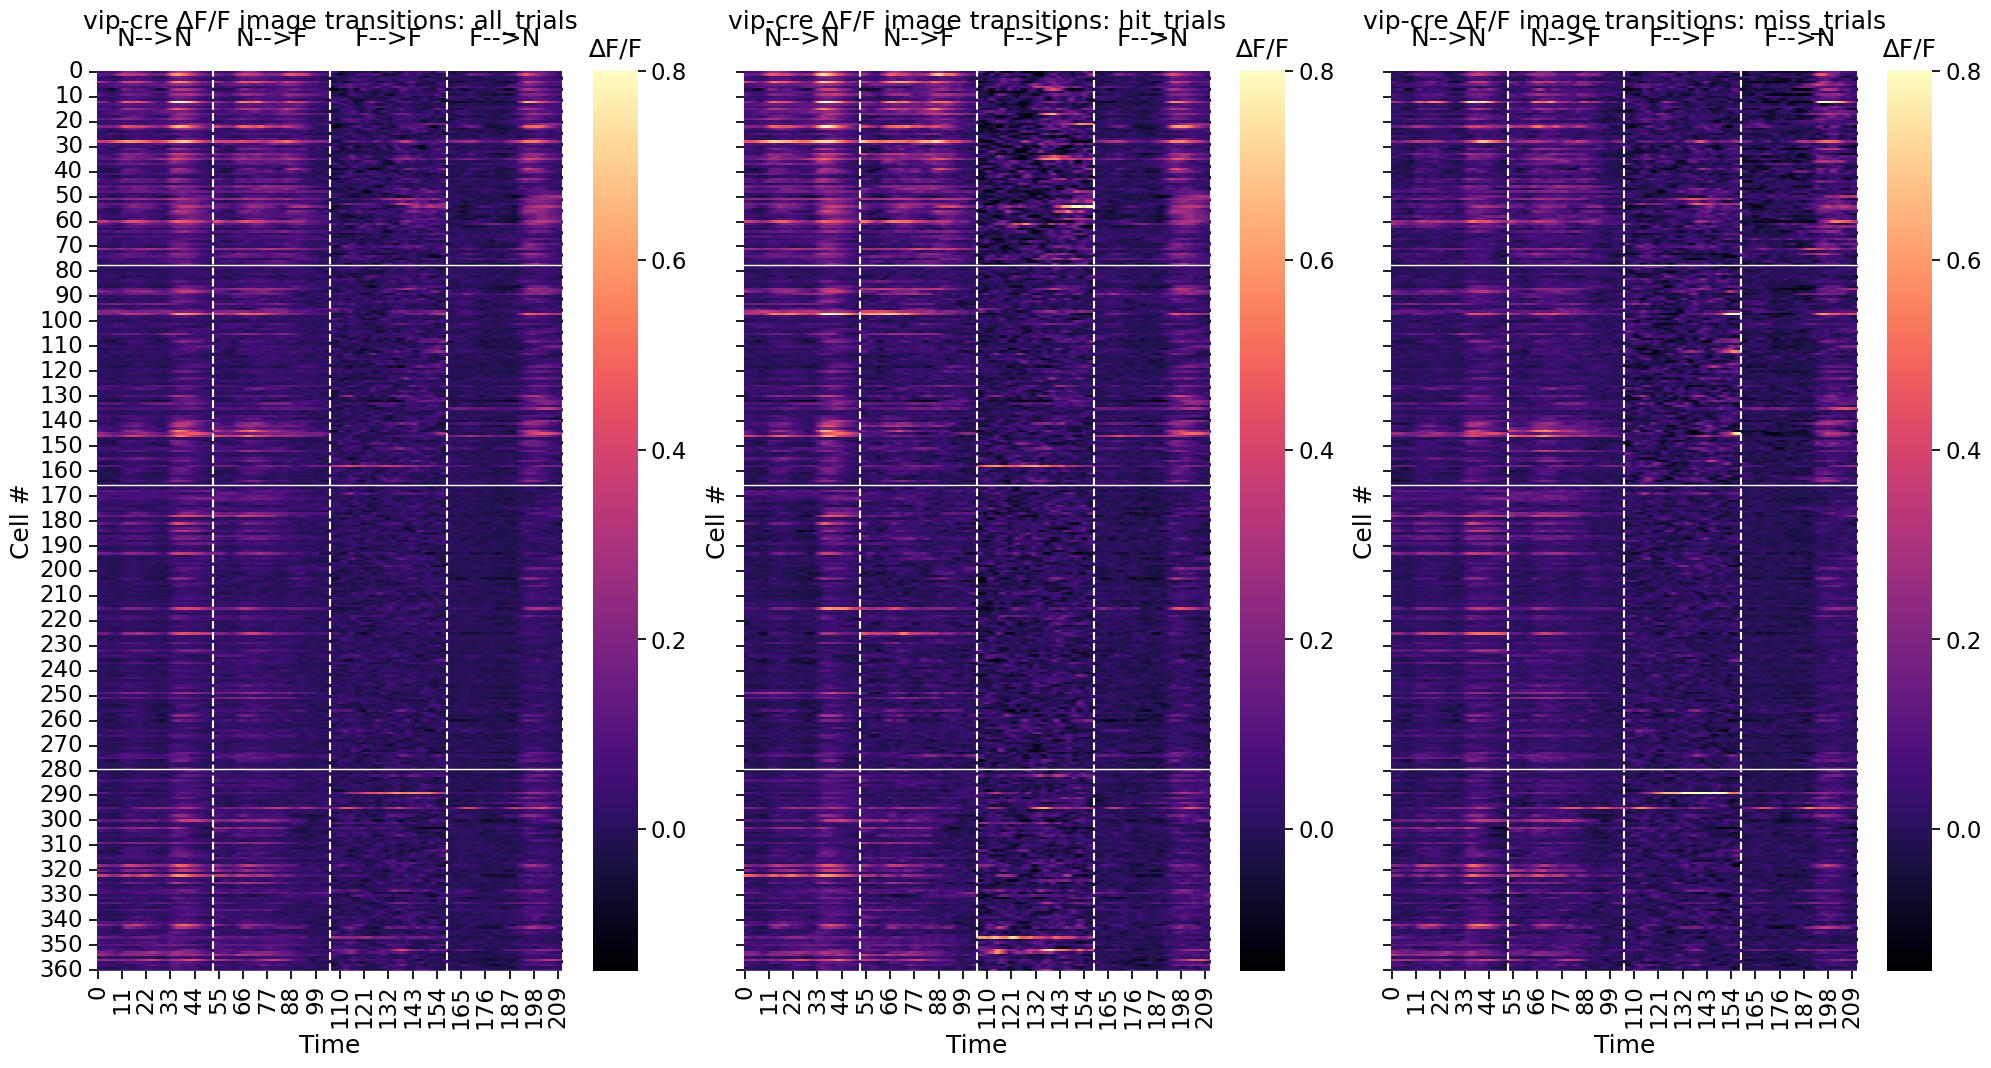

In [24]:
fig, axs = plt.subplots(1,3, sharey=True,
                        squeeze=False, #makes sure a 2D array of axs is always returned even if only 1 row/column
                        figsize = (20, 10), #have fig-size depend on number of companys/metrics
                        )
fig.tight_layout()

dff_flat_list = []

for n, dff_list in enumerate(dff_groups_list):
    dff_array = np.array(dff_list)
    
    dff_flat = dff_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)
    
    
    
    name_list = ['N-->N', 'N-->F', 'F-->F', 'F-->N']
    if n==2:
        sp = sns.heatmap(dff_flat,cmap='magma', ax=axs[0,n], vmin=-0.15, vmax=0.8)
    else:
        sp = sns.heatmap(dff_flat,cmap='magma', 
                         #cbar=False, 
                         ax=axs[0,n], vmin=-0.15, vmax=0.8)
    
    # sp = sns.heatmap(dff_flat,cmap='magma', ax=axs[0][n], vmin=-0.15, vmax=0.8)

    cbar = plt.gcf().axes[-1] 
    cbar.set_title('∆F/F', pad=10)  # Horizontal label
    #cbar.ax.yaxis.set_label_position('left')  # Position the label above the colorbar
    
    line_offset = 0
    for i in range(4):
        timepts = dff_array.shape[-1]
        sp.axvline(timepts*(i+1), color='w', linestyle='--')
        sp.text(timepts*(i+1)-timepts/2, -10, name_list[i], horizontalalignment='center')
        

        temp_df = vip_stacked_dict[mouse_id_list[i]]
        cell_ct = len(temp_df.cell_specimen_id.unique())
        sp.axhline(cell_ct + line_offset, color='w', linewidth=1)
        line_offset = line_offset + cell_ct

    # line_offset = 0
    # for mouse_id in mouse_id_list:
    #     temp_df = vip_stacked_dict[mouse_id]
    #     cell_ct = len(temp_df.cell_specimen_id.unique())
    #     plt.axhline(cell_ct + line_offset, color='w', linestyle='--', linewidth=1)
    #     line_offset = line_offset + cell_ct

    
    sp.set_title(f'{end_folder} ∆F/F image transitions: ' + groups_types_list[n], pad=30)
    sp.set_ylabel('Cell #');
    sp.set_xlabel('Time');
    
    dff_flat_list += [dff_flat]

# Save as SVG

#plt.savefig(image_path+'dff_heatmap_'+curr_name_svg, format="svg")

    

In [25]:
# fig, axs = plt.subplots(1,3, sharey=True,
#                         squeeze=False, #makes sure a 2D array of axs is always returned even if only 1 row/column
#                         figsize = (20, 10), #have fig-size depend on number of companys/metrics
#                         )
# fig.tight_layout()

# for n, filtevent_list in enumerate(filtevent_groups_list):
#     filtevent_array = np.array(filtevent_list)
    
#     filtevent_flat = filtevent_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)    
    
#     name_list = ['N-->N', 'N-->F', 'F-->F', 'F-->N']
#     if n==2:
#         sp = sns.heatmap(filtevent_flat,cmap='magma', ax=axs[0][n], 
#                          vmin=-0.025, vmax=0.15
#                         )
#     else:
#         sp = sns.heatmap(filtevent_flat,cmap='magma', 
#                          #cbar=False, 
#                          ax=axs[0][n], 
#                          vmin=-0.025, vmax=0.15
#                         )
    
#     # sp = sns.heatmap(events_flat,cmap='magma', ax=axs[0][n], vmin=-0.15, vmax=0.8)

#     cbar = plt.gcf().axes[-1] 
#     cbar.set_title('events', pad=10)  # Horizontal label
#     #cbar.ax.yaxis.set_label_position('left')  # Position the label above the colorbar
    
#     line_offset = 0
#     for i in range(4):
#         timepts = filtevent_array.shape[-1]
#         sp.axvline(timepts*(i+1), color='w', linestyle='--')
#         sp.text(timepts*(i+1)-timepts/2, -10, name_list[i], horizontalalignment='center')
        

#         temp_df = vip_stacked_dict[mouse_id_list[i]]
#         cell_ct = len(temp_df.cell_specimen_id.unique())
#         sp.axhline(cell_ct + line_offset, color='w', linewidth=1)
#         line_offset = line_offset + cell_ct

#     # line_offset = 0
#     # for mouse_id in mouse_id_list:
#     #     temp_df = vip_stacked_dict[mouse_id]
#     #     cell_ct = len(temp_df.cell_specimen_id.unique())
#     #     plt.axhline(cell_ct + line_offset, color='w', linestyle='--', linewidth=1)
#     #     line_offset = line_offset + cell_ct

    
#     sp.set_title(f'{end_folder} events image transitions: ' + groups_types_list[n], pad=30)
#     sp.set_ylabel('Cell #');
#     sp.set_xlabel('Time');

# # Save as SVG

# plt.savefig(image_path+'filtevents_heatmap_'+curr_name_svg, format="svg")

    

In [26]:
# # Create a 1x3 subplot
# fig, axs = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
# fig.tight_layout()

# # Loop over dff_groups_list and plot each on a different subplot
# for n, dff_array in enumerate(dff_groups_list):
#     dff_array = np.array(dff_groups_list[n])
#     dff_flat = dff_array.reshape(len(curr_df.cell_specimen_id.unique()), -1)

#     axs[n].plot(dff_flat.T)

#     for i in range(4):
#         timepts = dff_array.shape[-1]
#         axs[n].axvline(timepts * (i + 1), color='k', linestyle='--')

#         # Get the y-limit of the current subplot
#         plt.ylim([-3, 10])
#         ylim = axs[n].get_ylim()
#         upper_ylim = ylim[1]

#         # Add the text labels
#         axs[n].text(timepts * (i + 1) - timepts / 2, upper_ylim + 0.1, name_list[i], 
#                     horizontalalignment='center')

#     # Set the title, ylabel, and xlabel for each subplot
#     axs[n].set_title(f'{end_folder} image transitions: ' + groups_types_list[n], pad=35)
#     axs[n].set_ylabel('∆F/F')
#     axs[n].set_xlabel('Time')

# # Save the entire figure as an SVG (optional)
# plt.savefig(image_path+'dff_lineplots_'+curr_name_svg, format="svg")

# # Display the plot
# plt.show()

### PCA Setup

In [27]:
from sklearn.preprocessing import StandardScaler



In [28]:
from sklearn.decomposition import PCA



In [31]:
#import nmslib
  
#from pynndescent import PyNNDescentTransformer
#import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle

### PCA - Concatenated Hits and Misses

In [32]:
# dff_flat_list contains np flattened arrays for 0: all trials, 1: hit trials, and 2: miss trials
dff_concat = np.hstack((dff_flat_list[1], dff_flat_list[2]))

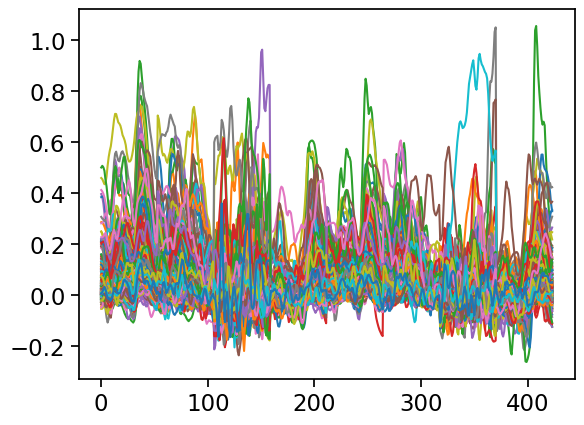

In [33]:
plt.plot(dff_concat.T);

In [34]:
# Fit and transform the data to get into PCA format
scaler = StandardScaler()
dff_for_pca = scaler.fit_transform(dff_concat)

In [35]:
dff_for_pca.shape

(361, 424)

In [36]:
# Transpose the data so that time points are the components and neurons are the features
dff_for_pca = dff_for_pca.T

In [37]:
dff_for_pca.shape

(424, 361)

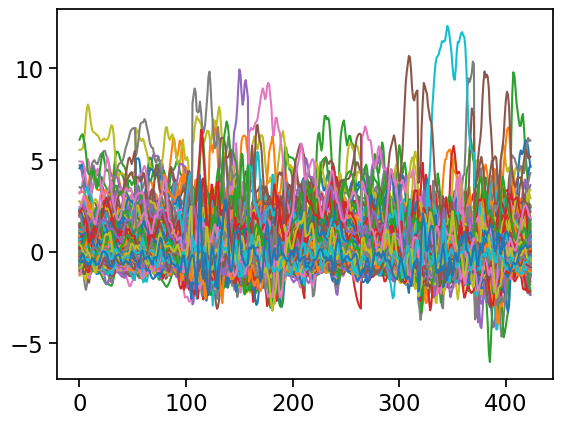

In [38]:
plt.plot(dff_for_pca);

In [40]:
time_bin = int(dff_for_pca.shape[0]/8)

# perform PCA
pca = PCA(n_components=time_bin)
x_pca = pca.fit_transform(dff_for_pca)

In [41]:
x_pca.shape

(424, 53)

Text(0, 0.5, 'var explained (%)')

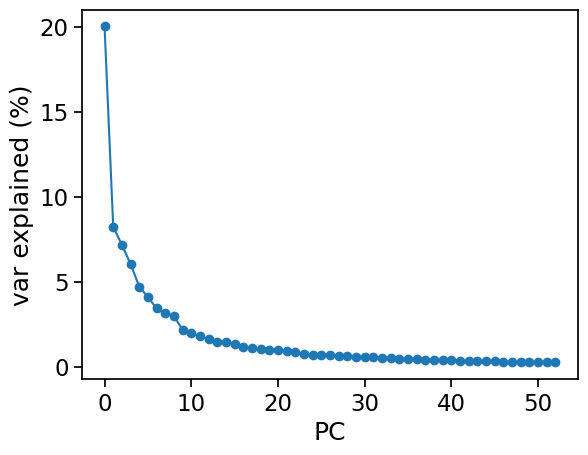

In [43]:
plt.plot(pca.explained_variance_ratio_*100, 'o-')
plt.xlabel('PC')
plt.ylabel('var explained (%)')

In [44]:
dff_for_pca.shape

(424, 361)

In [45]:
concat_responses_proj.shape

NameError: name 'concat_responses_proj' is not defined

In [ ]:
concat_responses_proj = pca.fit_transform(dff_for_pca) # samples x components


plt.scatter(concat_responses_proj[:,0], concat_responses_proj[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('time (s)')

In [ ]:
concat_responses_proj.shape

In [ ]:


plt.scatter(concat_responses_proj[:,1], concat_responses_proj[:,2])
plt.xlabel('PC2')
plt.ylabel('PC3')
cbar = plt.colorbar()
cbar.set_label('time (s)')

In [ ]:
# dff_test_array = np.array(dff_all_list) # cell x condition x time
# dff_test_array[:,0,:].T.shape

In [ ]:
dff_for_pca.shape

In [ ]:
dff_for_pca[:(time_bin*1),:].shape

In [ ]:
nf_responses_proj_hit.shape

In [ ]:
# get array containing nn, nf, ff, and fn responses for hits and misses
dff_hit_array = np.array(dff_hit_list) # cell x condition x time
dff_miss_array = np.array(dff_miss_list) # cell x condition x time

# # project responses to each image transition that was a hit onto top PCs
# nn_responses_proj_hit = pca.transform(dff_hit_array[:,0,:].T)
# nf_responses_proj_hit = pca.transform(dff_hit_array[:,1,:].T)
# ff_responses_proj_hit = pca.transform(dff_hit_array[:,2,:].T) # input should be samples x features
# fn_responses_proj_hit = pca.transform(dff_hit_array[:,3,:].T)

# # project responses to each image transition that was a miss type onto top PCs
# nn_responses_proj_miss = pca.transform(dff_miss_array[:,0,:].T)
# nf_responses_proj_miss = pca.transform(dff_miss_array[:,1,:].T)
# ff_responses_proj_miss = pca.transform(dff_miss_array[:,2,:].T) # input should be samples x features
# fn_responses_proj_miss = pca.transform(dff_miss_array[:,3,:].T)

# get the time bin for a single image transition type (e.g. N to N hit)
time_bin = int(dff_for_pca.shape[0]/8)

# project responses to each image transition that was a hit onto top PCs
nn_responses_proj_hit =  pca.fit_transform(dff_for_pca[:(time_bin*1),:])
nf_responses_proj_hit =  pca.fit_transform(dff_for_pca[(time_bin*1):(time_bin*2),:])
ff_responses_proj_hit =  pca.fit_transform(dff_for_pca[(time_bin*2):(time_bin*3),:])
fn_responses_proj_hit =  pca.fit_transform(dff_for_pca[(time_bin*3):(time_bin*4),:])

# project responses to each image transition that was a miss type onto top PCs
nn_responses_proj_miss =  pca.fit_transform(dff_for_pca[(time_bin*4):(time_bin*5),:])
nf_responses_proj_miss =  pca.fit_transform(dff_for_pca[(time_bin*5):(time_bin*6),:])
ff_responses_proj_miss =  pca.fit_transform(dff_for_pca[(time_bin*6):(time_bin*7),:]) # input should be samples x features
fn_responses_proj_miss =  pca.fit_transform(dff_for_pca[(time_bin*7):(time_bin*8),:])

# Plot the hit/miss transitions into PC space
fig = plt.figure()

a = .75
pc_idx_x = 0
pc_idx_y = 1
# plot hit transitions
plt.scatter(nn_responses_proj_hit[:,pc_idx_x], nn_responses_proj_hit[:,pc_idx_y], c='fuchsia', alpha=a, label=r'hit N$\rightarrow$N')
plt.scatter(nf_responses_proj_hit[:,pc_idx_x], nf_responses_proj_hit[:,pc_idx_y], c='gray', alpha=a, label=r'hit N$\rightarrow$F')
plt.scatter(ff_responses_proj_hit[:,pc_idx_x], ff_responses_proj_hit[:,pc_idx_y], c='black', alpha=a, label=r'hit F$\rightarrow$F')
plt.scatter(fn_responses_proj_hit[:,pc_idx_x], fn_responses_proj_hit[:,pc_idx_y], c='dodgerblue', alpha=a, label=r'hit F$\rightarrow$N')

# plot miss transitions
plt.scatter(nn_responses_proj_miss[:,pc_idx_x], nn_responses_proj_miss[:,pc_idx_y], facecolors='none', edgecolors='fuchsia', alpha=a, label=r'miss N$\rightarrow$N')
plt.scatter(nf_responses_proj_miss[:,pc_idx_x], nf_responses_proj_miss[:,pc_idx_y], facecolors='none', edgecolors='gray', alpha=a, label=r'miss N$\rightarrow$F')
plt.scatter(ff_responses_proj_miss[:,pc_idx_x], ff_responses_proj_miss[:,pc_idx_y], facecolors='none', edgecolors='black', alpha=a, label=r'miss F$\rightarrow$F')
plt.scatter(fn_responses_proj_miss[:,pc_idx_x], fn_responses_proj_miss[:,pc_idx_y], facecolors='none', edgecolors='dodgerblue', alpha=a, label=r'miss F$\rightarrow$N')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [ ]:
# get array containing nn, nf, ff, and fn responses for hits and misses
dff_hit_array = np.array(dff_hit_list) # cell x condition x time
dff_miss_array = np.array(dff_miss_list) # cell x condition x time

# project responses to each image transition that was a hit onto top PCs
nn_responses_proj_hit = pca.transform(dff_hit_array[:,0,:].T)
nf_responses_proj_hit = pca.transform(dff_hit_array[:,1,:].T)
ff_responses_proj_hit = pca.transform(dff_hit_array[:,2,:].T) # input should be samples x features
fn_responses_proj_hit = pca.transform(dff_hit_array[:,3,:].T)

# project responses to each image transition that was a miss type onto top PCs
nn_responses_proj_miss = pca.transform(dff_miss_array[:,0,:].T)
nf_responses_proj_miss = pca.transform(dff_miss_array[:,1,:].T)
ff_responses_proj_miss = pca.transform(dff_miss_array[:,2,:].T) # input should be samples x features
fn_responses_proj_miss = pca.transform(dff_miss_array[:,3,:].T)




a = .75
pc_idx_x = 1
pc_idx_y = 2
# plot hit transitions
plt.scatter(nn_responses_proj_hit[:,pc_idx_x], nn_responses_proj_hit[:,pc_idx_y], c='fuchsia', alpha=a, label=r'N$\rightarrow$N')
plt.scatter(nf_responses_proj_hit[:,pc_idx_x], nf_responses_proj_hit[:,pc_idx_y], c='gray', alpha=a, label=r'N$\rightarrow$F')
plt.scatter(ff_responses_proj_hit[:,pc_idx_x], ff_responses_proj_hit[:,pc_idx_y], c='black', alpha=a, label=r'F$\rightarrow$F')
plt.scatter(fn_responses_proj_hit[:,pc_idx_x], fn_responses_proj_hit[:,pc_idx_y], c='dodgerblue', alpha=a, label=r'F$\rightarrow$N')

# plot miss transitions
plt.scatter(nn_responses_proj_miss[:,pc_idx_x], nn_responses_proj_miss[:,pc_idx_y], facecolors='none', edgecolors='fuchsia', alpha=a, label=r'N$\rightarrow$N')
plt.scatter(nf_responses_proj_miss[:,pc_idx_x], nf_responses_proj_miss[:,pc_idx_y], facecolors='none', edgecolors='gray', alpha=a, label=r'N$\rightarrow$F')
plt.scatter(ff_responses_proj_miss[:,pc_idx_x], ff_responses_proj_miss[:,pc_idx_y], facecolors='none', edgecolors='black', alpha=a, label=r'F$\rightarrow$F')
plt.scatter(fn_responses_proj_miss[:,pc_idx_x], fn_responses_proj_miss[:,pc_idx_y], facecolors='none', edgecolors='dodgerblue', alpha=a, label=r'F$\rightarrow$N')

plt.xlabel('PC2')
plt.ylabel('PC3')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [ ]:
# get the time bin for a single image transition type (e.g. N to N hit)
time_bin = int(dff_for_pca.shape[0]/8)

# project responses to each image transition that was a hit onto top PCs
nn_responses_proj_hit =  pca.fit_transform(dff_for_pca[:(time_bin*1),:])
nf_responses_proj_hit =  pca.fit_transform(dff_for_pca[(time_bin*1):(time_bin*2),:])
ff_responses_proj_hit =  pca.fit_transform(dff_for_pca[(time_bin*2):(time_bin*3),:])
fn_responses_proj_hit =  pca.fit_transform(dff_for_pca[(time_bin*3):(time_bin*4),:])

# project responses to each image transition that was a miss type onto top PCs
nn_responses_proj_miss =  pca.fit_transform(dff_for_pca[(time_bin*4):(time_bin*5),:])
nf_responses_proj_miss =  pca.fit_transform(dff_for_pca[(time_bin*5):(time_bin*6),:])
ff_responses_proj_miss =  pca.fit_transform(dff_for_pca[(time_bin*6):(time_bin*7),:]) # input should be samples x features
fn_responses_proj_miss =  pca.fit_transform(dff_for_pca[(time_bin*7):(time_bin*8),:])

# Plot the hit/miss transitions into PC space
fig = plt.figure()

a = .75
pc_idx_x = 1
pc_idx_y = 2
# plot hit transitions
plt.scatter(nn_responses_proj_hit[:,pc_idx_x], nn_responses_proj_hit[:,pc_idx_y], c='fuchsia', alpha=a, label=r'hit N$\rightarrow$N')
plt.scatter(nf_responses_proj_hit[:,pc_idx_x], nf_responses_proj_hit[:,pc_idx_y], c='gray', alpha=a, label=r'hit N$\rightarrow$F')
plt.scatter(ff_responses_proj_hit[:,pc_idx_x], ff_responses_proj_hit[:,pc_idx_y], c='black', alpha=a, label=r'hit F$\rightarrow$F')
plt.scatter(fn_responses_proj_hit[:,pc_idx_x], fn_responses_proj_hit[:,pc_idx_y], c='dodgerblue', alpha=a, label=r'hit F$\rightarrow$N')

# plot miss transitions
plt.scatter(nn_responses_proj_miss[:,pc_idx_x], nn_responses_proj_miss[:,pc_idx_y], facecolors='none', edgecolors='fuchsia', alpha=a, label=r'miss N$\rightarrow$N')
plt.scatter(nf_responses_proj_miss[:,pc_idx_x], nf_responses_proj_miss[:,pc_idx_y], facecolors='none', edgecolors='gray', alpha=a, label=r'miss N$\rightarrow$F')
plt.scatter(ff_responses_proj_miss[:,pc_idx_x], ff_responses_proj_miss[:,pc_idx_y], facecolors='none', edgecolors='black', alpha=a, label=r'miss F$\rightarrow$F')
plt.scatter(fn_responses_proj_miss[:,pc_idx_x], fn_responses_proj_miss[:,pc_idx_y], facecolors='none', edgecolors='dodgerblue', alpha=a, label=r'miss F$\rightarrow$N')

plt.xlabel('PC2')
plt.ylabel('PC3')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

# PCA

### PCA Setup

### PCA - Colored by kmeans clusters

In [68]:
sorted_clustered_df.columns

Index(['targeted_structure_id', 'cell_specimen_id', 'z_all', 'z_hit', 'z_miss',
       'kmeans_labels', 'dff_all', 'dff_hit', 'dff_miss', 'dff_mean_nn',
       'dff_mean_nf', 'dff_mean_ff', 'dff_mean_fn'],
      dtype='object')

In [69]:
# Version 1: cluster based on mean response to each image change type
features = ['dff_mean_nn', 'dff_mean_nf', 'dff_mean_ff', 'dff_mean_fn']

# Separating out the features
x = sorted_clustered_df.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

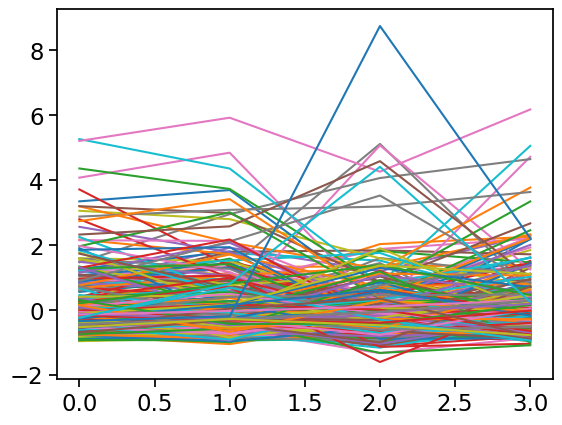

In [70]:
plt.plot(x.T);

In [71]:
# Version 2: cluster based on trace over image change types
features = ['dff_all']

x_array = np.array(sorted_clustered_df['dff_all'].tolist())
x = x_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)

x = stats.zscore(x,axis=1)
     

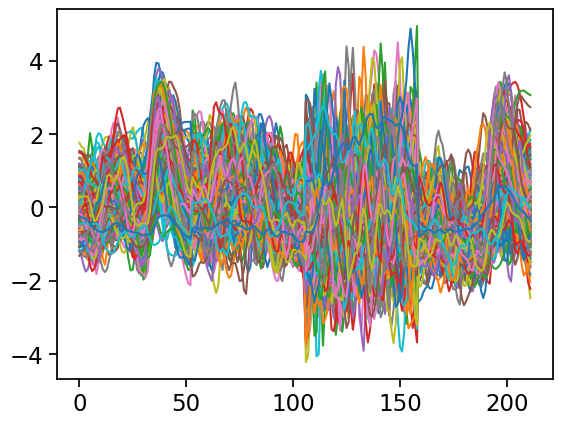

In [72]:
plt.plot(x.T);

In [73]:
# Separating out the target (CHOOSE TARGETED_STRUCTURE_ID OR KMEANS_LABELS)
y = sorted_clustered_df.loc[:,['kmeans_labels']].values



In [74]:
pca = PCA(n_components=4)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 
                          'principal component 3', 'principal component 4'
                         ])
                          

In [75]:
principalDf

,principal component 1,principal component 2,principal component 3,principal component 4
0,-0.770203,-4.954899,2.517904,0.342882
1,-1.825720,-1.208609,4.936015,-0.565677
2,-5.239796,0.637286,4.041806,0.245941
3,-7.887398,-0.744912,2.806110,-2.534135
4,4.533804,-2.049755,5.290164,-3.239620
...,...,...,...,...
356,-0.265784,-0.610606,2.557988,-1.534600
357,4.625304,-1.260777,3.924574,0.047304
358,-5.617064,-1.622349,-3.504753,1.600222
359,5.709536,14.629179,-5.830873,4.216921


In [76]:
finalDf = pd.concat([principalDf, sorted_clustered_df[['kmeans_labels', 'targeted_structure_id']]], axis = 1)


In [77]:
finalDf.shape

(361, 6)

## PCA Plots

### Colored by cluster

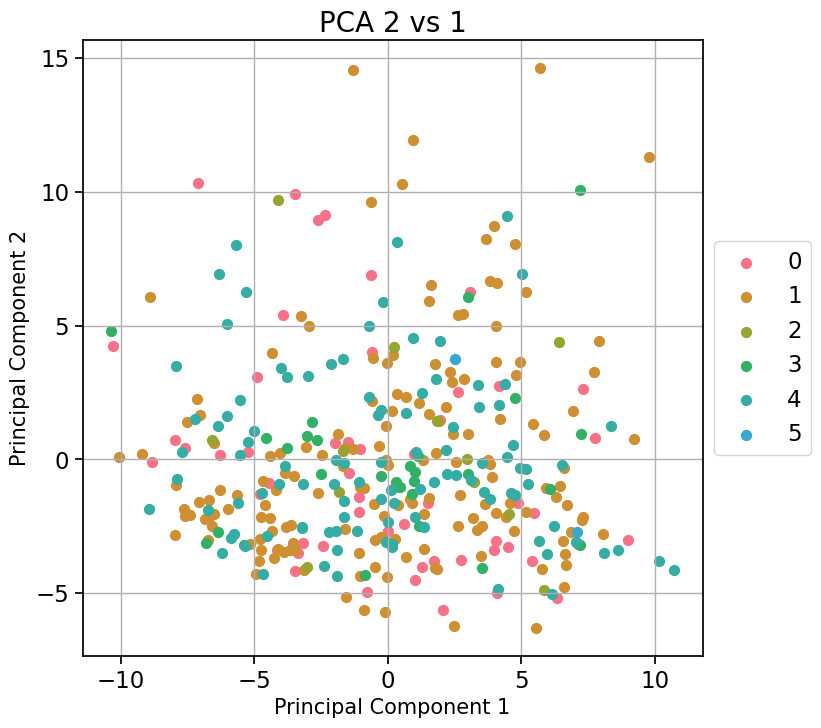

In [78]:
# Colored by functional cluster
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA 2 vs 1', fontsize = 20)

targets = sorted_clustered_df.kmeans_labels.unique()
hues = sns.color_palette("husl", 8)

#colors = ['r', 'g', 'b']
colors = hues[:len(targets)]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['kmeans_labels'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , color = color
               , s = 50)
ax.legend(targets,loc='center left', bbox_to_anchor=(1, 0.5));
ax.grid()

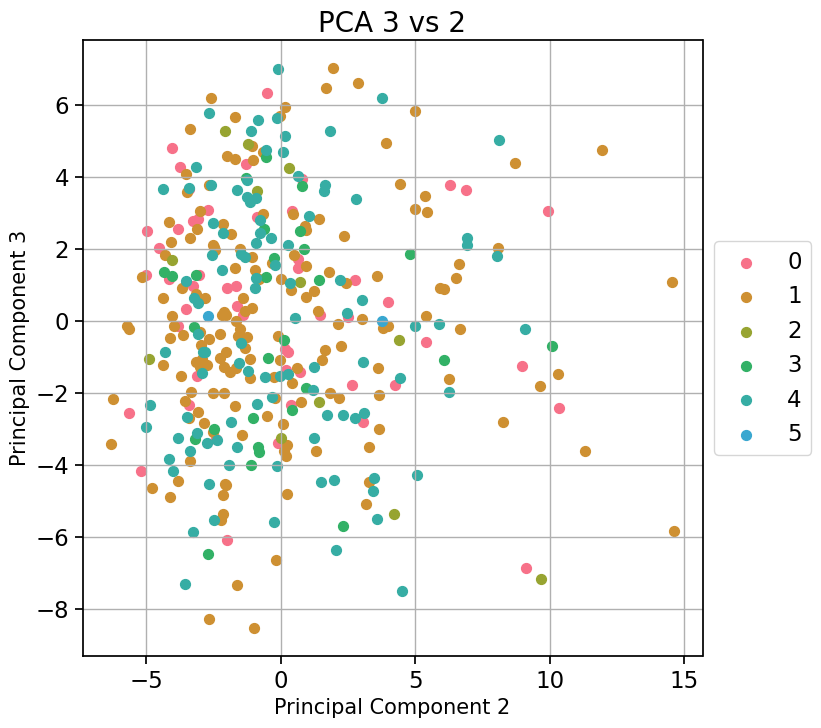

In [79]:
# Colored by functional cluster
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('PCA 3 vs 2', fontsize = 20)

targets = sorted_clustered_df.kmeans_labels.unique()
hues = sns.color_palette("husl", 8)

#colors = ['r', 'g', 'b']
colors = hues[:len(targets)]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['kmeans_labels'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , color = color
               , s = 50)
ax.legend(targets,loc='center left', bbox_to_anchor=(1, 0.5));

ax.grid()

### Colored by targeted structure

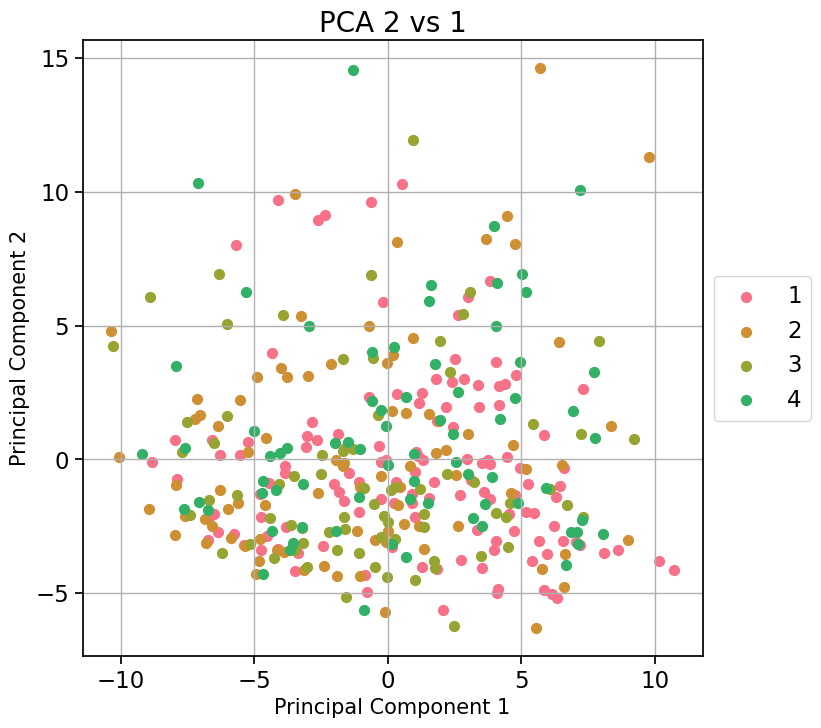

In [80]:
# Colored by functional cluster
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA 2 vs 1', fontsize = 20)

targets = sorted_clustered_df.targeted_structure_id.unique()
hues = sns.color_palette("husl", 8)

#colors = ['r', 'g', 'b']
colors = hues[:len(targets)]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['targeted_structure_id'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , color = color
               , s = 50)
ax.legend(targets,loc='center left', bbox_to_anchor=(1, 0.5));
ax.grid()

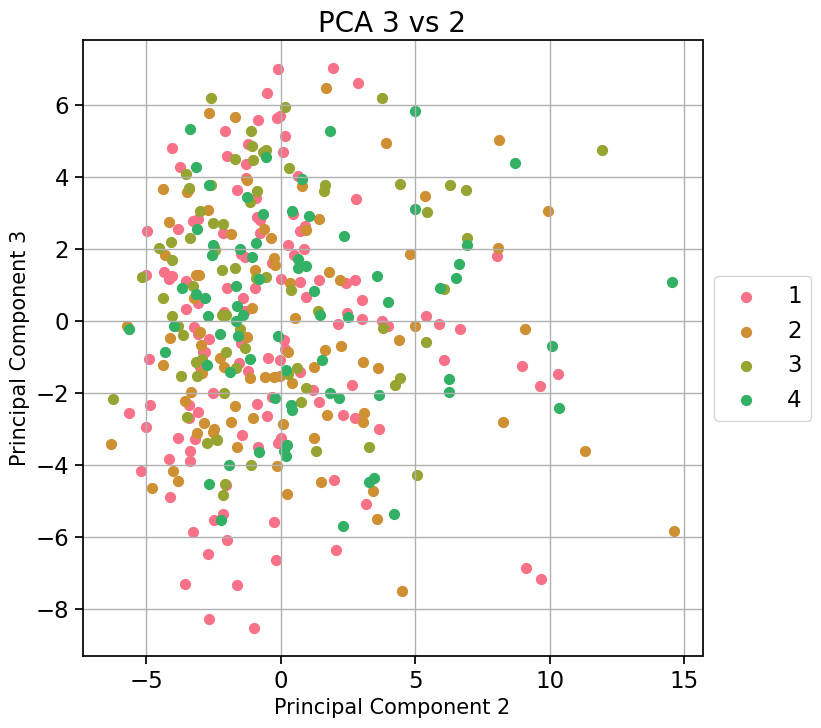

In [81]:
# Colored by functional cluster
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('PCA 3 vs 2', fontsize = 20)

targets = sorted_clustered_df.targeted_structure_id.unique()
hues = sns.color_palette("husl", 8)

#colors = ['r', 'g', 'b']
colors = hues[:len(targets)]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['targeted_structure_id'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , color = color
               , s = 50)
ax.legend(targets,loc='center left', bbox_to_anchor=(1, 0.5));
ax.grid()

# T-SNE

In [82]:
X.shape

(361, 212)

In [83]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)
X_embedded.shape
(4, 2)

(4, 2)